In [94]:
import pandas as pd
from rxnmapper import RXNMapper
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [3]:
df = pd.read_csv('/home/ruard/code/virtual_reactions/data/datasets/da/da_no_solvent_dataset.csv')
df

,Unnamed: 0,reaction_idx,uid,substrates,products,reaction_smiles,labels,simulation_idx
0,0,2,0,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C=C(Br)C1C(OC)(OC)C2=O,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,0,0.0
1,1,2,1,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C(Br)=CC1C(=O)C2(OC)OC,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,1,0.0
2,2,6,2,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1CC=CC12,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,1,0.0
3,3,6,3,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C(Cl)=C(Cl)C2(Cl)C3C=CC(C3)C12Cl,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,0,0.0
4,4,7,4,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1,CCC(=O)C1CC=CC(NC(=O)OCc2ccccc2)C1,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1>>CCC(=O)C1CC...,0,0.0
...,...,...,...,...,...,...,...,...
1162,1162,1679,1162,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CCC1(C(F)(F)F)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CCC1(...,0,0.0
1163,1163,1679,1163,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,FC(F)(F)C(=CC1CC=CCC1)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>FC(F)(F)C(=CC...,1,0.0
1164,1164,1679,1164,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CC(C(F)(F)F)(C(F)(F)F)C1,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CC(C(...,0,0.0
1165,1165,1680,1165,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1,O=C1C=CC(=O)C2(Cl)C3C=CC(C3)C12Cl,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1>>O=C1C=CC(=O)...,0,0.0


## Obtaining reaction core minimal reactions for all DA reactions

In [148]:
rxn_mapper = RXNMapper()

da_rxn_smarts = AllChem.ReactionFromSmarts(
    '[#6:1]=[#6:2].[#6:3]=[#6:4][#6:5]=[#6:6]>>[#6:1]1[#6:2][#6:3][#6:4]=[#6:5][#6:6]1'
)

_bondtypes = {
    1: Chem.BondType.SINGLE,
    2: Chem.BondType.DOUBLE
}

def simulate_da_reaction(substrates):
    products = []
    products += da_rxn_smarts.RunReactants(substrates)
    substrates = [substrates[1], substrates[0]]
    products += da_rxn_smarts.RunReactants(substrates)
    
    products = [Chem.MolToSmiles(product[0]) for product in products]
    products = list(set(products))
    return [Chem.MolFromSmiles(product) for product in products]

def get_core_reaction_from_smiles(reaction_smiles: str):
    reaction_smiles = rxn_mapper.get_attention_guided_atom_maps([reaction_smiles])[0]['mapped_rxn']
    rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction_smiles, useSmiles=True)
    rxn.Initialize()
    
    reacting_atoms = rxn.GetReactingAtoms()
    if len(reacting_atoms[0]) == 2 and len(reacting_atoms[1]) == 4:
        reactants = reaction_smiles.split('>>')[0].split('.')
        dienophile_smiles, dienophile_idxs = reactants[0], reacting_atoms[0]
        diene_smiles, diene_idxs = reactants[1], reacting_atoms[1]
    elif len(reacting_atoms[0]) ==4 and len(reacting_atoms[1]) == 2:
        reactants = reaction_smiles.split('>>')[0].split('.')
        dienophile_smiles, dienophile_idxs = reactants[1], reacting_atoms[1]
        diene_smiles, diene_idxs = reactants[0], reacting_atoms[0]
    else:
        return None
    
    
    # dienophile
    dienophile = Chem.AddHs(Chem.MolFromSmiles(dienophile_smiles))
    
    rdedmol = Chem.EditableMol(Chem.Mol())
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddBond(0, 1, _bondtypes[2])
    for i, idx in enumerate(dienophile_idxs):
        neighbors = dienophile.GetAtomWithIdx(idx).GetNeighbors()
        neighbors = [neighbor.GetAtomicNum() for neighbor in neighbors]
        neighbors.remove(6)
        for neighbor in neighbors:
            rdedmol.AddAtom(Chem.Atom(neighbor))
            rdedmol.AddBond(i, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
    
    dienophile_mol = rdedmol.GetMol()
    try:
        Chem.SanitizeMol(dienophile_mol)
    except:
        return None
    dienophile_smiles = Chem.MolToSmiles(dienophile_mol, isomericSmiles=True)
    
    
    # diene
    diene = Chem.AddHs(Chem.MolFromSmiles(diene_smiles))
    
    rdedmol = Chem.EditableMol(Chem.Mol())
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddAtom(Chem.Atom(6))
    rdedmol.AddBond(0, 1, _bondtypes[2])
    rdedmol.AddBond(1, 2, _bondtypes[1])
    rdedmol.AddBond(2, 3, _bondtypes[2])
    for i, idx in enumerate(diene_idxs):
        if i == 0 or i == 3:
            neighbors = diene.GetAtomWithIdx(idx).GetNeighbors()
            neighbors = [neighbor.GetAtomicNum() for neighbor in neighbors]
            neighbors.remove(6)
            for neighbor in neighbors:
                rdedmol.AddAtom(Chem.Atom(neighbor))
                rdedmol.AddBond(i, len(rdedmol.GetMol().GetAtoms()) - 1, _bondtypes[1])
    
    diene_mol = rdedmol.GetMol()
    try:
        Chem.SanitizeMol(diene_mol)
    except:
        return None
    diene_smiles = Chem.MolToSmiles(diene_mol, isomericSmiles=True)
    
    products = simulate_da_reaction([dienophile_mol, diene_mol])

    return f"{diene_smiles}.{dienophile_smiles}", f"{diene_smiles}.{dienophile_smiles}>>{Chem.MolToSmiles(products[0])}"
        

Some weights of the model checkpoint at /home/ruard/anaconda3/envs/ts/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [151]:
reaction_dict = {}

unmatched_reaction_smiles = []
for idx in range(len(df)):
    reaction_smiles = df['reaction_smiles'].values[idx]
    out = get_core_reaction_from_smiles(reaction_smiles)
    if out is not None:
        id_smiles, rxn_smiles = out
        if id_smiles not in reaction_dict.keys():
            reaction_dict[id_smiles] = rxn_smiles
    else:
        unmatched_reaction_smiles.append(reaction_smiles)
            
reactions = [v for k, v in reaction_dict.items()]
print(len(reactions))
print(len(unmatched_reaction_smiles))

146
252


In [152]:
new_df = df[~df['reaction_smiles'].isin(unmatched_reaction_smiles)]
print(len(new_df))
new_df.to_csv('/home/ruard/Downloads/test_da_reactions.csv')

915


In [153]:
with open('/home/ruard/Downloads/da_reaction_cores.txt', 'w') as f:
    f.writelines('\n'.join(reactions))

## Check quick if reaction core retrieval works

['C', 'H']
['C', 'H']
['C', 'H']
['C', 'H']


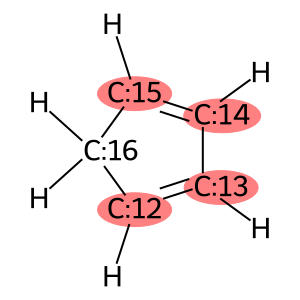

In [143]:
reaction_smiles = df['reaction_smiles'].values[3]

reaction_smiles = rxn_mapper.get_attention_guided_atom_maps([reaction_smiles])[0]['mapped_rxn']
rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction_smiles, useSmiles=True)
rxn.Initialize()

reacting_atoms = rxn.GetReactingAtoms()


reactants = reaction_smiles.split('>>')[0].split('.')
reactants = [Chem.MolFromSmiles(smi) for smi in reactants]
reactants = [Chem.AddHs(reactant) for reactant in reactants]

for idx in rxn.GetReactingAtoms()[0]:
    neighbors = reactants[0].GetAtomWithIdx(idx).GetNeighbors()
    neighbors = [neighbor.GetSymbol() for neighbor in neighbors]
    neighbors.remove('C')
    print(neighbors)

img = Draw.MolToImage(reactants[0], highlightAtoms=rxn.GetReactingAtoms()[0])
img

['Cl', 'C']


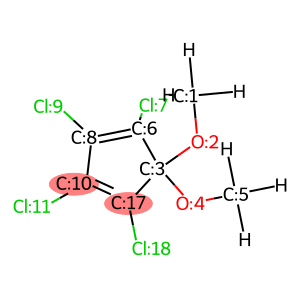

In [144]:
for i, idx in enumerate(rxn.GetReactingAtoms()[1]):
    if i == 0 or i == 3:
        neighbors = reactants[1].GetAtomWithIdx(idx).GetNeighbors()
        neighbors = [neighbor.GetSymbol() for neighbor in neighbors]
        neighbors.remove('C')
        print(neighbors)

img = Draw.MolToImage(reactants[1], highlightAtoms=rxn.GetReactingAtoms()[1])
img